# Imports

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import Literal

# Cleaning data 

## Helper Functions

In [2]:

def extract_distance(text):
    if isinstance(text, str):  # Ensure the text is a string

        # Match for 1/2 marathon (21.0975 km )
        matches = re.findall(r'1/2\s?marathon', text, re.IGNORECASE)
        if matches:
            return 21.0975  # 21.0975 km

        # Match for Semi-marathon (21.0975 km )
        matches = re.findall(r'Semi[-\s]?marathon|Semie[-\s]?marathon', text, re.IGNORECASE)
        if matches:
            return 21.0975  # 21.0975 km

        # Match for distances in kilometers (including optional space or underscore)
        matches = re.findall(r'(\d+)[\s_]?(km|kilometres?|k|bornes)', text, re.IGNORECASE)
        if matches:
            # Extract the number and the distance unit
            number = int(matches[0][0])  # Get the first matched number
            unit = matches[0][1].lower()  # Get the matched distance unit

            # If it's in kilometers (km, kilometres, k, bornes)
            if unit in ['km', 'kilometres', 'k', 'bornes']:
                return number

        # Handle marathon (full marathon) only if "marathon" appears alone and at the end of the string
        matches = re.findall(r'\bmarathon\b', text, re.IGNORECASE)
        if matches and not re.search(r'1/2\s?marathon|Semi[-\s]?marathon|Semie[-\s]?marathon', text, re.IGNORECASE):
            return 42.195  # Full marathon -> 42.195 km

        # Handle specific marathon distances (Full marathon and Semi-marathon)
        if '42.195' in text or '42,195' in text or '42.2' in text or '42,2' in text:
            return 42.195  # Full marathon -> 42.195 km
        if '21.0975' in text or '21,0975' in text or '21.1' in text or '21,1' in text:
            return 21.0975  # Semi-marathon -> 21.0975 km

        # Match for distances in meters (including optional space or underscore)
        matches = re.findall(r'\d+[\s_]?m', text, re.IGNORECASE)
        if matches:
            # Return meters directly (e.g., 5000m stays as 5000 meters)
            meters = re.findall(r'\d+', matches[0])
            if meters:  # Ensure we found a number
                return float(meters[0])/ 1000  # Return km

    return None  # Return None if no match is found

def extract_time_in_minuts(time_string):
    # Ensure the input is a string
    orginal = time_string
    if not isinstance(time_string, str):
        time_string = str(time_string)

    # Return None for empty strings or 'DNF'
    if not time_string or time_string.strip() == 'DNF':
        return None

    # Initialize time components
    hours = 0
    minutes = 0
    seconds = 0

    try:
        # Clean the string and handle brackets
        time_string = time_string.strip()

        # If there are brackets, use the content inside brackets
        if '(' in time_string and ')' in time_string:
            start = time_string.find('(')
            end = time_string.find(')')
            if start < end:
                time_string = time_string[start+1:end].strip()

        # Handle HH:MM:SS format (e.g., 1:14:36)
        if ':' in time_string:
            parts = time_string.split(':')
            if len(parts) == 3:  # HH:MM:SS format
                hours = int(parts[0])
                minutes = int(parts[1])
                seconds = int(parts[2])
            elif len(parts) == 2:  # MM:SS format
                minutes = int(parts[0])
                seconds = int(parts[1])

        # Handle HH' MM'' format (e.g., 1h34'43'' or h45'49''8)
        elif 'h' in time_string:
            # Split on 'h' and handle both cases: with and without space
            parts = time_string.split('h')
            if parts[0]:  # If there's something before 'h'
                hours = int(parts[0])
            time_string = parts[1].strip()

            if "'" in time_string:
                parts = time_string.split("'")
                if len(parts) >= 2:
                    minutes = int(parts[0])
                    if len(parts) >= 3:
                        seconds_str = parts[1].replace("''", "").strip()
                        if seconds_str:
                            seconds = int(seconds_str)

        # Handle MM' SS'' format (e.g., 34'43'' or '93''64)
        elif "'" in time_string:
            # Remove any leading/trailing quotes
            time_string = time_string.strip("'")

            # Split on remaining quotes
            parts = time_string.split("'")

            # Handle case where minutes and seconds are directly connected
            if len(parts) == 1 and "''" in time_string:
                # Split on double quotes
                parts = time_string.split("''")
                if len(parts) >= 2:
                    minutes = int(parts[0])
                    seconds = int(parts[1])
            else:
                if len(parts) >= 2:
                    minutes = int(parts[0])
                    if len(parts) >= 3:
                        seconds_str = parts[1].replace("''", "").strip()
                        if seconds_str:
                            seconds = int(seconds_str)

        # Calculate total seconds
        time_in_seconds = hours * 60 + minutes  + seconds/60
        return time_in_seconds if time_in_seconds > 0 else None
    except (ValueError, IndexError) as e:
        # Return None for any parsing errors
        # print(orginal, e)
        return None

In [3]:
def extract_time_in_minutes(time_string):
    """
    Extracts time from a formatted string and returns the total time in minutes as a float.

    Supported input formats:
    - "HH:MM:SS" (e.g., "1:14:36")
    - "MM:SS" (e.g., "14:36")
    - "XhY'Z''" (e.g., "1h34'43''")
    - "MM'SS''" (e.g., "16'50''")
    - Input can include brackets like " (1:14:36) ", which will be handled
    - "DNF" or empty values return None
    - Non-string inputs are converted to strings before processing

    Parameters:
    ----------
    time_string : str or any
        A string (or convertible to string) representing a time duration.

    Returns:
    -------
    float or None
        Time in total minutes (as a float), or None if the input is invalid.
    """
    original = time_string
    if not isinstance(time_string, str):
        time_string = str(time_string)

    # Return None for empty strings or 'DNF'
    if not time_string or time_string.strip().upper() == 'DNF':
        return None

    # Initialize time components
    hours = 0
    minutes = 0
    seconds = 0

    try:
        # Clean the string and remove surrounding whitespace
        time_string = time_string.strip()

        # Extract content inside parentheses, if any
        if '(' in time_string and ')' in time_string:
            start = time_string.find('(')
            end = time_string.find(')')
            if start < end:
                time_string = time_string[start + 1:end].strip()

        # Handle colon-separated time formats (HH:MM:SS or MM:SS)
        if ':' in time_string:
            parts = time_string.split(':')
            if len(parts) == 3:
                hours = int(parts[0])
                minutes = int(parts[1])
                seconds = int(parts[2])
            elif len(parts) == 2:
                minutes = int(parts[0])
                seconds = int(parts[1])

        # Handle formats like "1h34'43''"
        elif 'h' in time_string:
            parts = time_string.split('h')
            if parts[0]:  # hours before 'h'
                hours = int(parts[0])
            time_string = parts[1].strip()

            if "'" in time_string:
                parts = time_string.split("'")
                if len(parts) >= 2:
                    minutes = int(parts[0])
                    if len(parts) >= 3:
                        seconds_str = parts[1].replace("''", "").strip()
                        if seconds_str:
                            seconds = int(seconds_str)

        # Handle formats like "16'50''" (minutes and seconds)
        elif "'" in time_string:
            time_string = time_string.strip("'")
            parts = time_string.split("'")

            if len(parts) == 2:
                minutes = int(parts[0])
                seconds_str = parts[1].replace("''", "").strip()
                if seconds_str:
                    seconds = int(seconds_str)

        # Calculate total time in minutes
        time_in_minutes = hours * 60 + minutes + seconds / 60
        return time_in_minutes if time_in_minutes > 0 else None

    except (ValueError, IndexError):
        # Return None for parsing errors
        return None


## Main Part

In [4]:
df = pd.read_csv(r'data\raw_master_ffa_results.csv')
df = df.drop_duplicates()
df = df.drop('athlete_page',axis=1)
df.head()
df.describe()

,athlte,date_of_birth,weight,height,event_date,event_name,event_tour,performence,event_location,sex
count,2548857,2548857,2548857,2548857,2548857,2544870,2544170,2513010,2548857,2548857
unique,61996,818,89,86,2853,52293,1513,372648,10121,2
top,SAFFIOTI Franck,1973,-,-,13/01/2019,10 Km Route,H.Stade,DNF,Paris,M
freq,559,67955,1911376,1894592,8564,273524,1196441,3596,57239,2094409


### Extract distance and time and get pace

In [5]:
df['distance'] = df['event_name'].apply(extract_distance)
df["time"] = df['performence'].apply(extract_time_in_minutes)
df = df[~pd.isnull(df['distance']) & ~pd.isnull(df['time'])]
df["pace"] = df["time"]/df["distance"] # min/km
df = df[ df["pace"] < 12 ] #pace bigger than 12 is wrong -> marathon 8h 24 min
df = df[df["pace"] > 0.6]# pace faster than 0.6 -> faster tha record on 100 m
df.describe(include='all')

,athlte,date_of_birth,weight,height,event_date,event_name,event_tour,performence,event_location,sex,distance,time,pace
count,1425303,1425303,1425303,1425303,1425303,1425303,1425268,1425303,1425303,1425303,1.425303e+06,1.425303e+06,1.425303e+06
unique,60652,812,88,85,1850,23985,55,241653,8538,2,NaN,NaN,NaN
top,THOREZ Yohan,1973,-,-,17/03/2019,10 Km Route,H.Stade,39'49'',Paris,M,NaN,NaN,NaN
freq,429,46079,1093668,1086204,6364,273419,992465,462,49739,1202850,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.817397e+01,9.915264e+01,5.069520e+00
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.839962e+01,1.240890e+02,1.584240e+00
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.500000e-01,1.233333e+00,6.003058e-01
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+01,3.943333e+01,3.993759e+00
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.200000e+01,5.998333e+01,4.643333e+00
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.109750e+01,1.073167e+02,5.679167e+00


#### Get date of event and year of birth

In [6]:
df['event_date'] = pd.to_datetime(df['event_date'], format='%d/%m/%Y', errors='coerce')
df = df[~df['event_date'].isna()]
df['year_birth'] = df['date_of_birth'].apply(lambda d: d[-4:]  if isinstance(d,str) else str(d)[-4:] )
df =df[~df['year_birth'].isna()]


### Extract only road runs, flat runs

In [7]:
df['event_tour'].value_counts()

event_tour
H.Stade     992414
Trail       401123
Cross        19465
Mont.         4056
Relais 1      2475
Relais 2      2337
Final          869
Relais 3       588
Final 1        450
Relais 4       373
20 Km          172
10 Km          159
5 Km  1        127
Temps           85
50 Km           75
Relais 5        65
Relais 6        58
10 Km 1         43
10 km           43
100 K           41
6.5 k           39
1               30
Passa           21
35 Km           14
5 Km            10
Voie             9
50 km            9
10 km 1          6
57 km            6
16 km 1          5
SEMI             5
5000m            5
3 Km             3
Temps 1          3
20 km            3
10km             3
temps            2
3 km             2
3km M            2
2km M            2
Souil            2
10KM             2
Tp de            2
TEMPS            2
final            2
5 KM             1
2 Km             1
Saint            1
20 Km 1          1
5km m            1
GRAND            1
35km             1
t

In [8]:
# df = df[(df['event_tour'] == "H.Stade") | (df['event_tour'] == "Final 1") | (df['event_tour'] == "Final 2")]
df = df[(df['event_tour'] == "H.Stade") ]
df = df[~df['event_name'].str.contains('d+ ', na=False,regex=False)] # Removes runs with elevation
df.describe(include='all')

,athlte,date_of_birth,weight,height,event_date,event_name,event_tour,performence,event_location,sex,distance,time,pace,year_birth
count,991537,991537,991537,991537,991537,991537,991537,991537,991537,991537,991537.000000,991537.000000,991537.000000,991537
unique,58547,802,88,83,NaN,11714,1,202341,6371,2,NaN,NaN,NaN,85
top,SAFFIOTI Franck,1973,-,-,NaN,10 Km Route,H.Stade,38'50'',Paris,M,NaN,NaN,NaN,1973
freq,330,31228,747524,741913,NaN,272945,991537,415,46127,833844,NaN,NaN,NaN,31706
mean,NaN,NaN,NaN,NaN,2019-11-17 20:16:26.671804160,NaN,NaN,NaN,NaN,NaN,15.707105,74.190810,4.639429,NaN
min,NaN,NaN,NaN,NaN,2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.250000,1.233333,0.600866,NaN
25%,NaN,NaN,NaN,NaN,2017-04-29 00:00:00,NaN,NaN,NaN,NaN,NaN,10.000000,37.183333,3.843333,NaN
50%,NaN,NaN,NaN,NaN,2019-04-20 00:00:00,NaN,NaN,NaN,NaN,NaN,10.000000,46.616667,4.318333,NaN
75%,NaN,NaN,NaN,NaN,2022-10-09 00:00:00,NaN,NaN,NaN,NaN,NaN,21.000000,87.066667,5.042462,NaN
max,NaN,NaN,NaN,NaN,2025-05-04 00:00:00,NaN,NaN,NaN,NaN,NaN,1397.000000,11121.750000,11.997917,NaN


### Outliers 

np.float64(52.0)

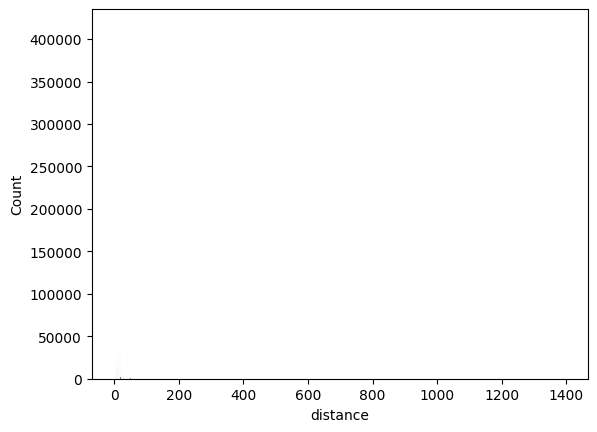

In [9]:
# df['distance'].plot(kind='hist')
sns.histplot(df, x='distance')
np.quantile(df['distance'], q=0.99)


<Axes: xlabel='distance', ylabel='Count'>

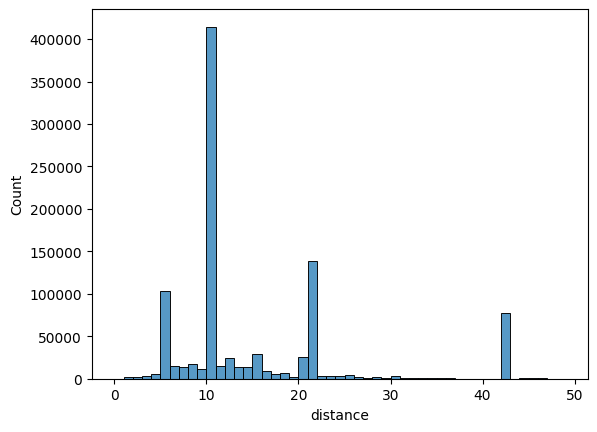

In [10]:
# Take only distance between 1km and 50 km and
df = df[(df['distance'] <= 50) & (df['distance'] >= 1)]
sns.histplot(df, x='distance', bins= np.arange(50)) # main 5k, 10k, half-marathon, marathon

<Axes: xlabel='distance', ylabel='Count'>

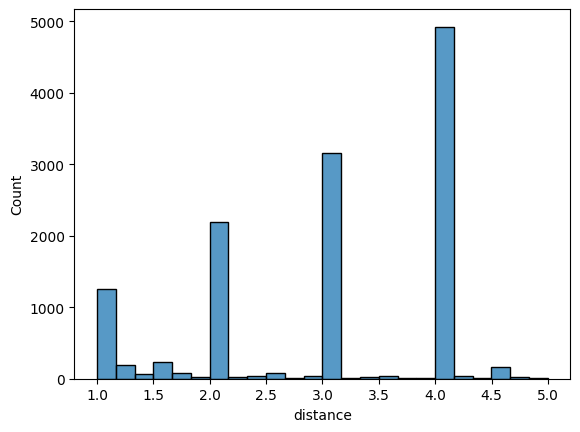

In [11]:
temp_df = df[df['distance'] < 5]
sns.histplot(temp_df, x='distance')

#### Remove faster runs than word records

In [12]:
men_record_pace_on_1km = (2 + 11/60) / 1  # time 2:11.96
men_record_pace_on_5km = (12 + 35/60)/5   # time 12:35.36
men_record_pace_on_10km = (26 + 24/60)/10  # time 26 minutes and 24 seconds
men_record_pace_on_halfmarathon = (56 + 42/60)/21.0975  # time 56:42
men_record_pace_on_marathon = (1*60 + 59 + 40/60)/42.195  # unofficial 1:59:40.2 official 2:00:35

women_record_pace_on_1km = (2 + 28/60)/1  # time 2:28.98
women_record_pace_on_5km = (14 + 0/60)/5   # time 14:00.21
women_record_pace_on_10km = (28 + 54/60)/10  # time 28:54.14
women_record_pace_on_halfmarathon = (1*60 + 2 + 42/60)/21.0975  # time 1:02:52
women_record_pace_on_marathon = (2*60 + 9 + 56/60)/42.195  # time 2:09:56

# Create masks for men and women separately
men_mask = (
    (df['sex'] == 'M') &
    (
        ((df['distance'] >= 1) & (df['distance'] < 5) & (df['pace'] > men_record_pace_on_1km)) |
        ((df['distance'] >= 5) & (df['distance'] < 10) & (df['pace'] > men_record_pace_on_5km)) |
        ((df['distance'] >= 10) & (df['distance'] < 21.0975) & (df['pace'] > men_record_pace_on_10km)) |
        ((df['distance'] >= 21.0975) & (df['distance'] < 42.195) & (df['pace'] > men_record_pace_on_halfmarathon)) |
        ((df['distance'] >= 42.195) & (df['pace'] > men_record_pace_on_marathon))
    )
)

women_mask = (
    (df['sex'] == 'F') &
    (
        ((df['distance'] >= 1) & (df['distance'] < 5) & (df['pace'] > women_record_pace_on_1km)) |
        ((df['distance'] >= 5) & (df['distance'] < 10) & (df['pace'] > women_record_pace_on_5km)) |
        ((df['distance'] >= 10) & (df['distance'] < 21.0975) & (df['pace'] > women_record_pace_on_10km)) |
        ((df['distance'] >= 21.0975) & (df['distance'] < 42.195) & (df['pace'] > women_record_pace_on_halfmarathon)) |
        ((df['distance'] >= 42.195) & (df['pace'] > women_record_pace_on_marathon))
    )
)

# Combine masks and filter dataframe
df = df[men_mask | women_mask]
df.head()

,athlte,date_of_birth,weight,height,event_date,event_name,event_tour,performence,event_location,sex,distance,time,pace,year_birth
45,SALMI Mustapha (Alg),1999,58kg,171cm,2017-10-22,10 Km Route,H.Stade,34'43'',Bois Guillaume,M,10.0,34.716667,3.471667,1999
46,SALMI Mustapha (Alg),1999,58kg,171cm,2017-09-24,10 Km Route,H.Stade,35'12'',Evreux,M,10.0,35.200000,3.520000,1999
47,SALMI Mustapha (Alg),1999,58kg,171cm,2017-08-27,10 kml,H.Stade,38'13'',Heudebouville,M,10.0,38.216667,3.821667,1999
63,SALMI Mustapha (Alg),1999,58kg,171cm,2018-10-21,10 Km Route,H.Stade,33'49'' (33'48''),Sausheim,M,10.0,33.800000,3.380000,1999
65,SALMI Mustapha (Alg),1999,58kg,171cm,2018-09-16,10 Km Route,H.Stade,33'09'' (32'52''),Rouen,M,10.0,32.866667,3.286667,1999


### fix distances 1% of errr

In [13]:
popular_distances = [0.4,0.8,1,1.5,1.61,2,3,4,5,10,21.0975,42.195]
for distance in popular_distances:
    df.loc[(df['distance'] > distance*0.99) & (df['distance'] < distance*1.01), 'distance'] = distance

### Filter to calulat BMI (optional)

                  athlte date_of_birth  weight  height event_date  \
45  SALMI Mustapha (Alg)          1999    58.0    1.71 2017-10-22   
46  SALMI Mustapha (Alg)          1999    58.0    1.71 2017-09-24   
47  SALMI Mustapha (Alg)          1999    58.0    1.71 2017-08-27   
63  SALMI Mustapha (Alg)          1999    58.0    1.71 2018-10-21   
65  SALMI Mustapha (Alg)          1999    58.0    1.71 2018-09-16   

     event_name event_tour        performence  event_location sex  distance  \
45  10 Km Route    H.Stade            34'43''  Bois Guillaume   M      10.0   
46  10 Km Route    H.Stade            35'12''          Evreux   M      10.0   
47       10 kml    H.Stade            38'13''   Heudebouville   M      10.0   
63  10 Km Route    H.Stade  33'49'' (33'48'')        Sausheim   M      10.0   
65  10 Km Route    H.Stade  33'09'' (32'52'')           Rouen   M      10.0   

         time      pace year_birth        bmi  
45  34.716667  3.471667       1999  19.835163  
46  35.200000 

<Axes: >

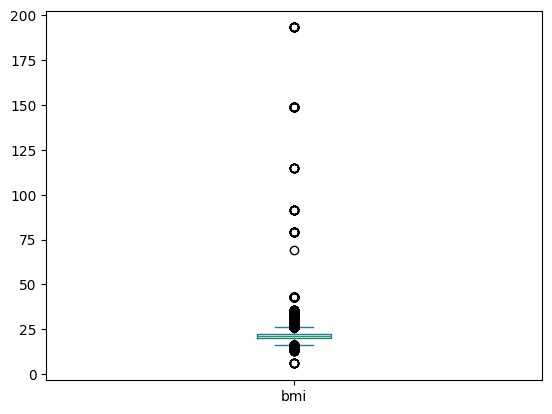

In [14]:
df = df[(df['height'] != '-') & (df['weight'] != '-')]
df['height'] = df['height'].apply(lambda h:  float(h[:-2]) / 100 if isinstance(h,str) else h)   # convert cm to m
df['weight'] = df['weight'].apply(lambda w:  float(w[:-2])  if isinstance(w,str) else w)  # extract numeric value from weight
df['bmi'] = df['weight'] / (df['height']**2)
print(df.head())
print(len(df['athlte'].unique()))
df.bmi.plot(kind='box')


#### Remove outliers in BMI

<Axes: >

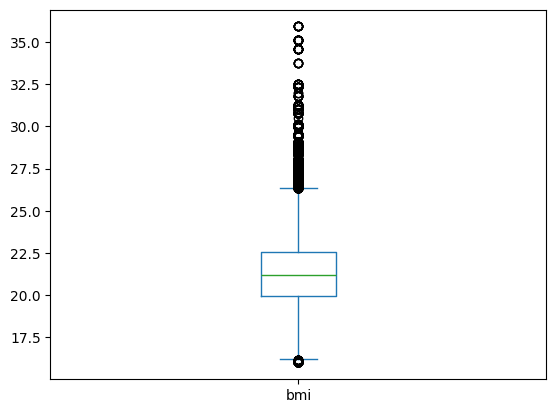

In [15]:
df = df[(df['bmi'] <= 40)& (df['bmi'] > 16 )] # Between Severe Thinness	 and Obese Class III
df['bmi'].plot(kind='box')

## Make dataset

### helper functions


In [18]:
def get_past_events(group, past_days=180):
    # Ensure the group is sorted by event_date
    group = group.sort_values("event_date", ascending=False)

    # Initialize lists to store the past events and counts for each row
    past_events_list = []
    past_events_count = []

    # Loop over each row in the group
    for idx, row in group.iterrows():
        # Define the cutoff date
        cutoff = row["event_date"] - pd.DateOffset(days=past_days)
        # Identify events in the past given period (excluding the current event)
        mask = (group["event_date"] >= cutoff) & (group["event_date"] < row["event_date"]) & (group['distance'] != row['distance'])
        # Create a list of dictionaries for the events within the given period of time
        events= group.loc[mask, ["event_date", "distance", "time", "pace"]]
        events["days_before"] = (row["event_date"] - events["event_date"]).dt.days
        events=events.drop("event_date",axis = 1)
        events = events.to_dict("records")
        # events = group.loc[mask, ["event_date", "distance", "time", "pace"]].to_dict("records")
        # Append results for this row
        # if len(events) < 2:
        #     continue
        past_events_list.append(events)
        past_events_count.append(len(events))

    # After looping, assign the collected lists to new columns
    group["past_events"] = past_events_list
    group["#past_events"] = past_events_count
    group = group[group["#past_events"] >1] # at least 2 previous events
    return group

def extract_wanted_race_from_past(group: pd.DataFrame, main_distance: Literal["marathon", "half-marathon"] = "marathon") -> pd.DataFrame:
    """
    Extracts and processes past event data to find the relevant races based on distances and pacing for future events.

    Args:
    - group (pd.DataFrame): DataFrame containing details of past events, including 'event_date', 'distance',
                             'time', 'pace', and 'past_events'.
    - main_distance (str, optional): The main race distance type, either "marathon" or "half-marathon". Default is "marathon".

    Returns:
    - pd.DataFrame: The input group DataFrame with additional columns indicating race details, status, and distances
                     relevant to the main event.
    """

    # Sort the group by event date in descending order
    group = group.sort_values("event_date", ascending=False)

    # Set race distance thresholds based on the type of main event
    if main_distance == "marathon":
        first_distance = 21.0975  # Half-marathon distance
        second_distance = 10  # 10k distance
    elif main_distance == "half-marathon":
        first_distance = 10  # 10k distance
        second_distance = 5  # 5k distance
    else:
        raise ValueError(f"Invalid value for main_distance: {main_distance}. Expected 'marathon' or 'half-marathon'.")

    # Initialize necessary columns in the group
    group['status'] = 'ok'
    group['first distance'] = None
    group['first time'] = None
    group["first days before main event"] = None
    group['second distance'] = None
    group['second time'] = None
    group["second days before main event"] = None

    # Start with the last used event date
    last_used_event = group['event_date'].iloc[0]

    # Iterate through the group DataFrame to process each row
    for index, row in group.iterrows():
        # Skip rows where the event date is later than the last used event
        if row['event_date'] > last_used_event:
            group.loc[index, 'status'] = "event was used in another record"
            continue

        # Extract main distance for the current event
        main_distance = row['distance']

        # Retrieve and filter past events based on the required distances
        previous_runs_df = pd.DataFrame(row['past_events'])
        previous_runs_df = previous_runs_df[previous_runs_df['pace'] <= row['pace']]
        previous_runs_df = previous_runs_df[previous_runs_df["distance"].isin([first_distance, second_distance])]

        # Check if both required distances are present
        if first_distance not in previous_runs_df["distance"].values or second_distance not in previous_runs_df["distance"].values:
            group.loc[index, 'status'] = "no required runs"
            continue

        # Get the best pace for the longer distance (first distance)
        best_pace_for_longer_distance = np.min(previous_runs_df[previous_runs_df['distance'] == first_distance]['pace'].values)

        # Filter runs where the pace is better (lower) than the best pace for the longer distance
        previous_runs_df = previous_runs_df[previous_runs_df['pace'] <= best_pace_for_longer_distance]

        # Check if the second distance is still available after filtering
        if second_distance not in previous_runs_df["distance"].values:
            group.loc[index, 'status'] = f"Pace for the best {first_distance} is faster than paces for {second_distance}"
            continue

        # Retrieve and assign the first distance (half-marathon or 10k) race data
        first_distance_df = previous_runs_df[previous_runs_df['distance'] == first_distance].iloc[0]
        group.loc[index, 'first distance'] = first_distance_df['distance']
        group.loc[index, 'first time'] = first_distance_df['time']
        group.loc[index, 'first days before main event'] = first_distance_df['days_before']

        # Retrieve and assign the second distance (10k or 5k) race data, sorted by pace and days before the event
        second_distance_df = previous_runs_df[previous_runs_df['distance'] == second_distance].sort_values(
            ['pace', 'days_before'], ascending=[True, True]).iloc[0]
        group.loc[index, 'second distance'] = second_distance_df['distance']
        group.loc[index, 'second time'] = second_distance_df['time']
        group.loc[index, 'second days before main event'] = second_distance_df['days_before']

        # Update the last used event date to avoid reusing the same event in another record
        last_used_event = row['event_date'] - pd.DateOffset(
            days=max(first_distance_df['days_before'], second_distance_df['days_before'])
        )

    return group

In [19]:
temp = df.copy()
temp = temp.sort_values(["athlte", "event_date"],ascending=False )
temp["age"] = temp["event_date"].dt.year - temp["year_birth"].astype(float) # age by year
temp = temp.loc[:, ["athlte", "event_date","age","weight","height","bmi","sex","distance","time","pace"]]
temp = temp.groupby("athlte", group_keys=False).apply(get_past_events,180)
temp

C:\Users\karczews\AppData\Local\Temp\ipykernel_20096\684539703.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp = temp.groupby("athlte", group_keys=False).apply(get_past_events,180)


,athlte,event_date,age,weight,height,bmi,sex,distance,time,pace,past_events,#past_events
1162763,ABADIE Paul,2025-03-30,29.0,62.0,1.80,19.135802,M,5.0,14.800000,2.960000,"[{'distance': 10.0, 'time': 30.4, 'pace': 3.04...",2
1162758,ABADIE Paul,2024-04-07,28.0,62.0,1.80,19.135802,M,5.0,15.483333,3.096667,"[{'distance': 10.0, 'time': 30.933333333333334...",2
1162658,ABADIE Paul,2017-10-22,21.0,62.0,1.80,19.135802,M,10.0,34.083333,3.408333,"[{'distance': 2.0, 'time': 21.666666666666668,...",2
1162660,ABADIE Paul,2017-07-23,21.0,62.0,1.80,19.135802,M,2.0,21.666667,10.833333,"[{'distance': 3.0, 'time': 9.516666666666667, ...",2
1287808,ABADIE Philippe,2022-12-10,26.0,61.0,1.70,21.107266,M,10.0,44.150000,4.415000,"[{'distance': 21.0975, 'time': 79.95, 'pace': ...",2
...,...,...,...,...,...,...,...,...,...,...,...,...
2028614,ZUTTER Julien,2025-04-12,37.0,53.0,1.69,18.556773,F,5.0,17.483333,3.496667,"[{'distance': 10.0, 'time': 34.2, 'pace': 3.42...",3
2028599,ZUTTER Julien,2019-01-06,31.0,53.0,1.69,18.556773,F,10.0,32.583333,3.258333,"[{'distance': 20.0, 'time': 69.7, 'pace': 3.48...",2
2028544,ZUTTER Julien,2018-12-30,30.0,53.0,1.69,18.556773,F,10.0,32.816667,3.281667,"[{'distance': 20.0, 'time': 69.7, 'pace': 3.48...",2
2028548,ZUTTER Julien,2018-10-21,30.0,53.0,1.69,18.556773,F,10.0,33.450000,3.345000,"[{'distance': 20.0, 'time': 69.7, 'pace': 3.48...",2


### Marathon_df

In [20]:
marathon_df = temp[temp["distance"]==42.195]
marathon_df = marathon_df.groupby('athlte').apply(extract_wanted_race_from_past, "marathon")
marathon_df = marathon_df[marathon_df['status']=='ok']
marathon_df

C:\Users\karczews\AppData\Local\Temp\ipykernel_20096\1618966946.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  marathon_df = marathon_df.groupby('athlte').apply(extract_wanted_race_from_past, "marathon")


athlte event_date   age  weight  \
athlte                                                                        
ABAROGE Farida (ETH) 1853324  ABAROGE Farida (ETH) 2019-05-12  53.0    75.0   
                     1853308  ABAROGE Farida (ETH) 2017-05-08  51.0    75.0   
ABDELMALEK Morad     2118438      ABDELMALEK Morad 2018-04-08  40.0    76.0   
                     2118430      ABDELMALEK Morad 2017-04-09  39.0    76.0   
ABDI Kamel           2027696            ABDI Kamel 2017-04-09  34.0    61.0   
...                                            ...        ...   ...     ...   
ZOUAOUI Brahim       475217         ZOUAOUI Brahim 2022-10-15  44.0    64.0   
ZOUEIN Adonis        631122          ZOUEIN Adonis 2022-11-27  49.0    67.0   
                     631131          ZOUEIN Adonis 2022-05-21  49.0    67.0   
                     631109          ZOUEIN Adonis 2021-11-28  48.0    67.0   
                     631092          ZOUEIN Adonis 2019-06-01  46.0    67.0   

                              height        bmi sex  distance        time  \
athlte                                                                      
ABAROGE Farida (ETH) 1853324    1.85  21.913806   M    42.195  191.416667   
                     1853308    1.85  21.913806   M    42.195  199.800000   
ABDELMALEK Morad     2118438    1.90  21.052632   M    42.195  175.966667   
                     2118430    1.90  21.052632   M    42.195  174.750000   
ABDI Kamel           2027696    1.72  20.619254   M    42.195  181.800000   
...                              ...        ...  ..       ...         ...   
ZOUAOUI Brahim       475217     1.75  20.897959   M    42.195  165.483333   
ZOUEIN Adonis        631122     1.71  22.913033   M    42.195  184.866667   
                     631131     1.71  22.913033   M    42.195  189.166667   
                     631109     1.71  22.913033   M    42.195  191.833333   
                     631092     1.71  22.913033   M    42.195  282.216667   

                                  pace  \
athlte                                   
ABAROGE Farida (ETH) 1853324  4.536477   
                     1853308  4.735158   
ABDELMALEK Morad     2118438  4.170320   
                     2118430  4.141486   
ABDI Kamel           2027696  4.308567   
...                                ...   
ZOUAOUI Brahim       475217   3.921871   
ZOUEIN Adonis        631122   4.381246   
                     631131   4.483154   
                     631109   4.546352   
                     631092   6.688391   

                                                                    past_events  \
athlte                                                                            
ABAROGE Farida (ETH) 1853324  [{'distance': 10.0, 'time': 39.38333333333333,...   
                     1853308  [{'distance': 21.0975, 'time': 87.366666666666...   
ABDELMALEK Morad     2118438  [{'distance': 21.0975, 'time': 78.7, 'pace': 3...   
                     2118430  [{'distance': 21.0975, 'time': 78.45, 'pace': ...   
ABDI Kamel           2027696  [{'distance': 10.0, 'time': 33.583333333333336...   
...                                                                         ...   
ZOUAOUI Brahim       475217   [{'distance': 21.0975, 'time': 70.0, 'pace': 3...   
ZOUEIN Adonis        631122   [{'distance': 10.0, 'time': 38.4, 'pace': 3.84...   
                     631131   [{'distance': 10.0, 'time': 39.56666666666667,...   
                     631109   [{'distance': 10.0, 'time': 38.733333333333334...   
                     631092   [{'distance': 10.0, 'time': 44.2, 'pace': 4.42...   

                              #past_events status first distance first time  \
athlte                                                                        
ABAROGE Farida (ETH) 1853324             4     ok        21.0975      88.45   
                     1853308             2     ok        21.0975  87.366667   
ABDELMALEK Morad     2118438             7     ok        21.0975       

#### Final marathon df

In [21]:
final_marathon_df  = marathon_df[['age','weight','height','sex','distance','time','first distance', 'first time', 'first days before main event',
       'second distance', 'second time', 'second days before main event']].reset_index(drop=True)
final_marathon_df.to_csv("data/marathon_dataset.csv", index=False, header=True)


### Half-marathon df

In [22]:
halfmarathon_df = temp[temp["distance"]==21.0975]
halfmarathon_df =halfmarathon_df.groupby('athlte').apply(extract_wanted_race_from_past, "half-marathon")
halfmarathon_df = halfmarathon_df[halfmarathon_df['status']=='ok']
halfmarathon_df

C:\Users\karczews\AppData\Local\Temp\ipykernel_20096\3851224171.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  halfmarathon_df =halfmarathon_df.groupby('athlte').apply(extract_wanted_race_from_past, "half-marathon")


athlte  \
athlte                                                                   
ABAROGE Farida (ETH)           1853355            ABAROGE Farida (ETH)   
ABDELKARIM Abdelmoumaine (Sud) 219674   ABDELKARIM Abdelmoumaine (Sud)   
                               219663   ABDELKARIM Abdelmoumaine (Sud)   
                               219668   ABDELKARIM Abdelmoumaine (Sud)   
                               219624   ABDELKARIM Abdelmoumaine (Sud)   
...                                                                ...   
ZOUAOUI Brahim                 475161                   ZOUAOUI Brahim   
                               475107                   ZOUAOUI Brahim   
                               475118                   ZOUAOUI Brahim   
                               475122                   ZOUAOUI Brahim   
                               475088                   ZOUAOUI Brahim   

                                       event_date   age  weight  height  \
athlte                                                                    
ABAROGE Farida (ETH)           1853355 2022-03-13  56.0    75.0    1.85   
ABDELKARIM Abdelmoumaine (Sud) 219674  2024-09-29  24.0    46.0    1.66   
                               219663  2023-09-24  23.0    46.0    1.66   
                               219668  2023-03-05  23.0    46.0    1.66   
                               219624  2019-09-15  19.0    46.0    1.66   
...                                           ...   ...     ...     ...   
ZOUAOUI Brahim                 475161  2018-09-16  40.0    64.0    1.75   
                               475107  2016-10-23  38.0    64.0    1.75   
                               475118  2016-05-08  38.0    64.0    1.75   
                               475122  2016-03-13  38.0    64.0    1.75   
                               475088  2015-09-13  37.0    64.0    1.75   

                                              bmi sex  distance       time  \
athlte                                                                       
ABAROGE Farida (ETH)           1853355  21.913806   M   21.0975  91.633333   
ABDELKARIM Abdelmoumaine (Sud) 219674   16.693279   M   21.0975  71.816667   
                               219663   16.693279   M   21.0975  70.633333   
                               219668   16.693279   M   21.0975  72.683333   
                               219624   16.693279   M   21.0975  74.650000   
...                                           ...  ..       ...        ...   
ZOUAOUI Brahim                 475161   20.897959   M   21.0975  74.783333   
                               475107   20.897959   M   21.0975  73.383333   
                               475118   20.897959   M   21.0975  71.633333   
                               475122   20.897959   M   21.0975  71.200000   
                               475088   20.897959   M   21.0975  72.633333   

                                            pace  \
athlte                                             
ABAROGE Farida (ETH)           1853355  4.343327   
ABDELKARIM Abdelmoumaine (Sud) 219674   3.404037   
                               219663   3.347948   
                               219668   3.445116   
                               219624   3.538334   
...                                          ...   
ZOUAOUI Brahim                 475161   3.544654   
                               475107   3.478295   
                               475118   3.395347   
                               475122   3.374807   
                               475088   3.442746   

                                                                              past_events  \
athlte                                                                                      
ABAROGE Farida (ETH)           1853355  [{'distance': 10.0, 'time': 42.166666666666664...   
ABDELKARIM Abdelmoumaine (Sud) 219674   [{'distance': 10.0, 'time': 32.166666666666664...   
                               219663   [{'distance': 5.0, 't

#### Final half-marathon df 

In [23]:
final_halfmarathon_df  = halfmarathon_df[['age','weight','height','sex','distance','time','first distance', 'first time', 'first days before main event',
       'second distance', 'second time', 'second days before main event']].reset_index(drop=True)
final_halfmarathon_df.to_csv("data/halfmarathon_dataset.csv", index=False, header=True)


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

marathon_df = pd.read_csv('data/marathon_dataset.csv')
marathon_df['bmi'] = marathon_df['weight'] / (marathon_df['height']**2)
marathon_df = marathon_df.drop(['distance','first distance','second distance'],errors='ignore',axis=1)
marathon_df['sex'].value_counts()

sex
M    3790
F     486
Name: count, dtype: int64

In [25]:
halfmarathon_df = pd.read_csv('data/halfmarathon_dataset.csv')
halfmarathon_df['bmi'] = halfmarathon_df['weight'] / (halfmarathon_df['height']**2)
halfmarathon_df = halfmarathon_df.drop(['distance','first distance','second distance'],errors='ignore',axis=1)
halfmarathon_df['sex'].value_counts()
halfmarathon_df.describe()
halfmarathon_df['sex'].value_counts()

sex
M    1510
F     234
Name: count, dtype: int64

In [27]:
marathon_df = pd.read_csv('data/marathon_dataset.csv')
marathon_df['bmi'] = marathon_df['weight'] / (marathon_df['height']**2)

halfmarathon_df = pd.read_csv('data/halfmarathon_dataset.csv')
halfmarathon_df['bmi'] = halfmarathon_df['weight'] / (halfmarathon_df['height']**2)

df = pd.concat([marathon_df,halfmarathon_df]).reset_index(drop=True)
df.columns

Index(['age', 'weight', 'height', 'sex', 'distance', 'time', 'first distance',
       'first time', 'first days before main event', 'second distance',
       'second time', 'second days before main event', 'bmi'],
      dtype='object')

In [33]:
halfmarathon_df

,age,weight,height,sex,distance,time,first distance,first time,first days before main event,second distance,second time,second days before main event,bmi
0,56.0,75.0,1.85,M,21.0975,91.633333,10.0,42.166667,84.0,5.0,20.933333,85.0,21.913806
1,24.0,46.0,1.66,M,21.0975,71.816667,10.0,32.166667,120.0,5.0,15.633333,126.0,16.693279
2,23.0,46.0,1.66,M,21.0975,70.633333,10.0,32.933333,113.0,5.0,15.566667,7.0,16.693279
3,23.0,46.0,1.66,M,21.0975,72.683333,10.0,34.216667,147.0,5.0,16.100000,140.0,16.693279
4,19.0,46.0,1.66,M,21.0975,74.650000,10.0,34.366667,77.0,5.0,17.033333,141.0,16.693279
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,40.0,64.0,1.75,M,21.0975,74.783333,10.0,32.616667,105.0,5.0,15.883333,141.0,20.897959
1740,38.0,64.0,1.75,M,21.0975,73.383333,10.0,32.166667,141.0,5.0,15.533333,15.0,20.897959
1741,38.0,64.0,1.75,M,21.0975,71.633333,10.0,32.266667,14.0,5.0,15.800000,41.0,20.897959
1742,38.0,64.0,1.75,M,21.0975,71.200000,10.0,32.266667,35.0,5.0,15.683333,168.0,20.897959


In [29]:
df['sex'].value_counts()

sex
M    5300
F     720
Name: count, dtype: int64

In [28]:
df.groupby('sex').agg('quantile',[0.25,0.75])

age  weight  height  distance        time  first distance  \
sex                                                                    
F   0.25  33.0    48.0    1.60   21.0975  103.558333         10.0000   
    0.75  46.0    55.0    1.67   42.1950  211.000000         21.0975   
M   0.25  34.0    62.0    1.72   21.0975   99.966667         10.0000   
    0.75  48.0    71.0    1.80   42.1950  198.470833         21.0975   

          first time  first days before main event  second distance  \
sex                                                                   
F   0.25   45.720833                          28.0              5.0   
    0.75   95.783333                         119.0             10.0   
M   0.25   42.508333                          28.0              5.0   
    0.75   88.033333                         105.0             10.0   

          second time  second days before main event        bmi  
sex                                                              
F   0.25    21.879167                           49.0  18.132017  
    0.75    43.200000                          140.0  19.979188  
M   0.25    20.250000                           49.0  20.451146  
    0.75    39.220833                          140.0  22.598140

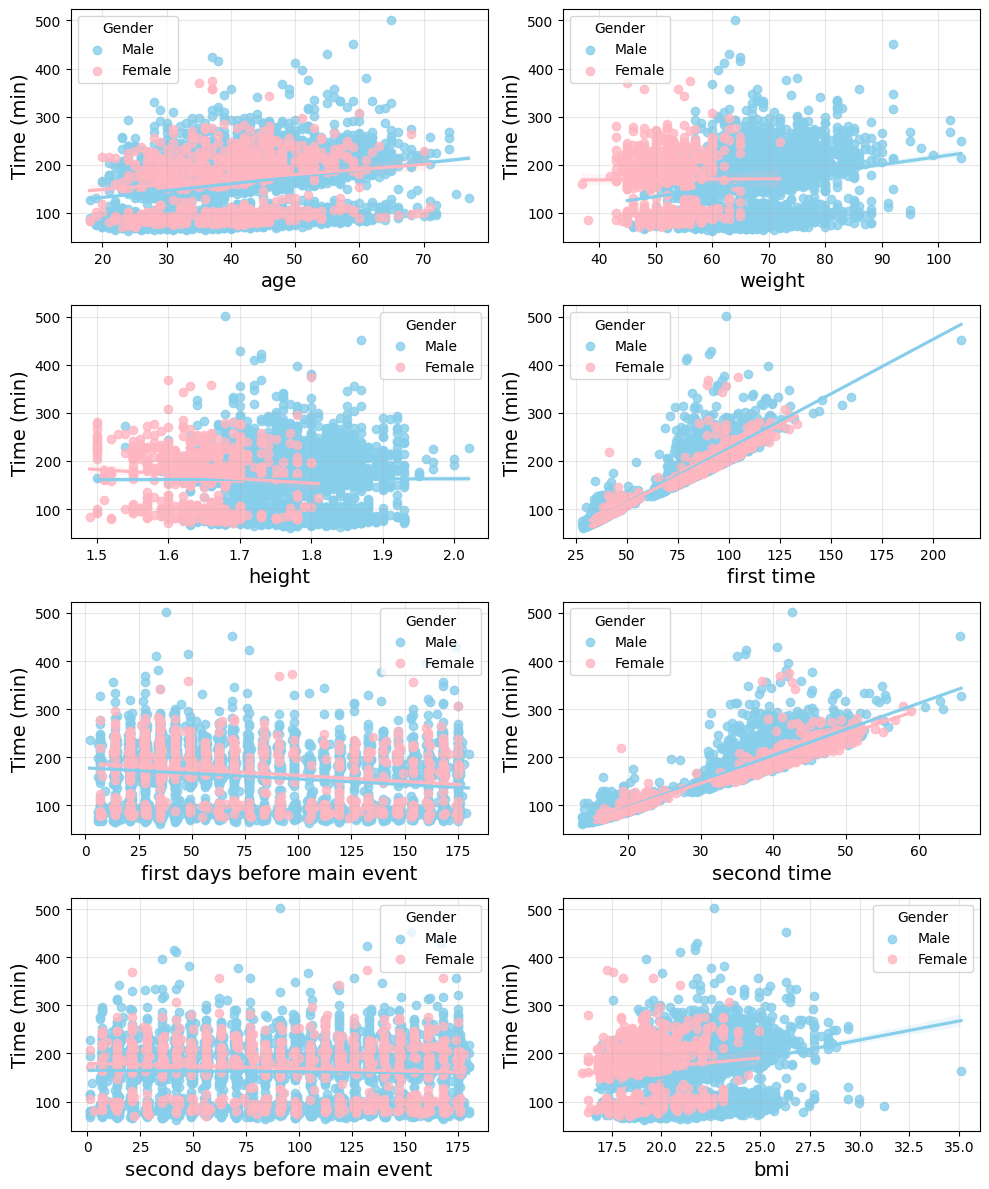

In [32]:

features = df.drop(['time','sex','distance', 'first distance', 'second distance'],axis=1).columns
n_features = len(features)
n_cols = 2
n_rows = (n_features + 1) // 2  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3*n_rows))
axes = axes.flatten()

# Plot each feature vs time
for idx, feature in enumerate(features):
    # Create scatter plot with regression line for each gender
    sns.regplot(data=df[df['sex']=='M'],
                x=feature, y='time', scatter=True,
                color='skyblue', ax=axes[idx], label='Male')
    sns.regplot(data=df[df['sex']=='F'],
                x=feature, y='time', scatter=True,
                color='lightpink', ax=axes[idx], label='Female')

    axes[idx].set_xlabel(feature, fontsize=14)
    axes[idx].set_ylabel('Time (min)', fontsize=14)
    axes[idx].grid(alpha=0.3)

    # Create a single legend for both plots
    handles, labels = axes[idx].get_legend_handles_labels()
    axes[idx].legend(handles[:2], ['Male', 'Female'], title='Gender')

# Remove any empty subplots
for idx in range(len(features), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig('figs/combaine_feature_analysis.pdf', dpi=300)

